In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,silhouette_score 
from sklearn.cluster import KMeans
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#1.MIT-BIH for PVC: https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
#https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
#http://www.tara.tcd.ie/bitstream/handle/2262/17623/automatic.pdf?sequence=1
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 180 #left sample length around of peak value of QRS
#get trainset
mbPCV = [] #[Subject,sig_name,QRS]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230,\
            100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:
    #44 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['V']:#PVC samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    for j, val in enumerate(lead_name):
                        QRS_value = signal[:,j][min_idx:max_idx]
                        mbPCV.append([bt,lead_name[j],QRS_value])#[Subject,sig_name,QRS]
    except: pass
mbPCV = pd.DataFrame(np.array(mbPCV),columns=['sub','lead','qrs'])
mbPCV_QRS = pd.DataFrame(mbPCV['qrs'].values.tolist()) #QRS extrend
mbPCV = mbPCV.drop(['qrs'],axis=1) #drop column 2
#mbPCV = mbPCV.rename(columns={"0": "sub", "1": "lead"})
mbPCV = pd.concat([mbPCV, mbPCV_QRS], axis=1)
print('The shape of MIT-BIH for PVC is: (%d,%d)'%(mbPCV.shape[0],mbPCV.shape[1]))

#2. AHA2MIT for PVC：https://archive.physionet.org/physiobank/annotations.shtml
rootdir = '/data/fjsdata/ECG/AHA2MIT'
filename = list(set( [os.path.splitext(base)[0] for base in os.listdir(rootdir)]) )
amPCV = [] #[Subject,sig_name,QRS]
for bt in filename:#154 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        #print (list(set(qrs_sym)))
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['V']:#PVC samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    for j, val in enumerate(lead_name):
                        QRS_value = signal[:,j][min_idx:max_idx]
                        amPCV.append([bt,lead_name[j],QRS_value])#[Subject,sig_name,QRS]
    except:pass
amPCV = pd.DataFrame(np.array(amPCV),columns=['sub','lead','qrs'])
amPCV_QRS = pd.DataFrame(amPCV['qrs'].values.tolist()) #QRS extrend
amPCV = amPCV.drop(['qrs'],axis=1) #drop column 2
amPCV = pd.concat([amPCV, amPCV_QRS], axis=1)
print('The shape of AHA2MIT for PVC is: (%d,%d)'%(amPCV.shape[0],amPCV.shape[1]))

The shape of MIT-BIH for PVC is: (13804,362)
The shape of AHA2MIT for PVC is: (62344,362)


In [4]:
#Trainset and Testset: MIT-BIH (lead = 'MLII')
mbPCV_MLII = mbPCV[mbPCV['lead']=='MLII']
#print (mbPCV_MLII['sub'].value_counts())
X = mbPCV_MLII.drop(['sub','lead'],axis=1)
best_score = 0.0
best_k = 1
distortions = []
for k in range(2,9):
    estimator = KMeans(n_clusters=k, random_state=0).fit(X)
    distortions.append(estimator.inertia_)
    si_score = silhouette_score(X,estimator.labels_,metric='euclidean')
    if si_score>best_score:
        best_score = si_score
        best_k = k
print('best K is:%d and its silhouette score is:%f'%(best_k,best_score))
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
#predict every subject 
sub_list = list(set(mbPCV_MLII['sub'].tolist()))
print(len(sub_list))
rec_pvc = []
for sub in sub_list:
    PCV_sub = mbPCV_MLII[mbPCV_MLII['sub']==sub].reset_index(drop=True)
    X_sub = PCV_sub.drop(['sub','lead'],axis=1)
    pvc_num = X_sub.shape[0]
    k_sub = kmeans.predict(X_sub)
    k_num = len(list(set(k_sub.tolist())))
    if k_num>1:
        rec_pvc.append([sub,k_num,pvc_num])
print(len(rec_pvc))

best K is:3 and its silhouette score is:0.353035
33
23


In [34]:
#import ecg_plot#pip install ecg_plot, https://pypi.org/project/ecg-plot/
#from scipy.misc import electrocardiogram 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html
fs = 360
X = mbPCV_MLII.drop(['sub','lead'],axis=1).reset_index(drop=True) 
X_sub = np.array(mbPCV_MLII['sub']).tolist()
y = kmeans.predict(X).tolist()
for idx,row in X.iterrows():
    svpath = os.path.join('/data/fjsdata/ECG/PVC/MIT-BIH-MLII/',str(X_sub[idx])+'-'+str(idx)+'-'+str(y[idx]))
    ecg = np.array(row)
    time_fs = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time_fs, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X.shape[0]))
    sys.stdout.flush()

6901 / 6902 

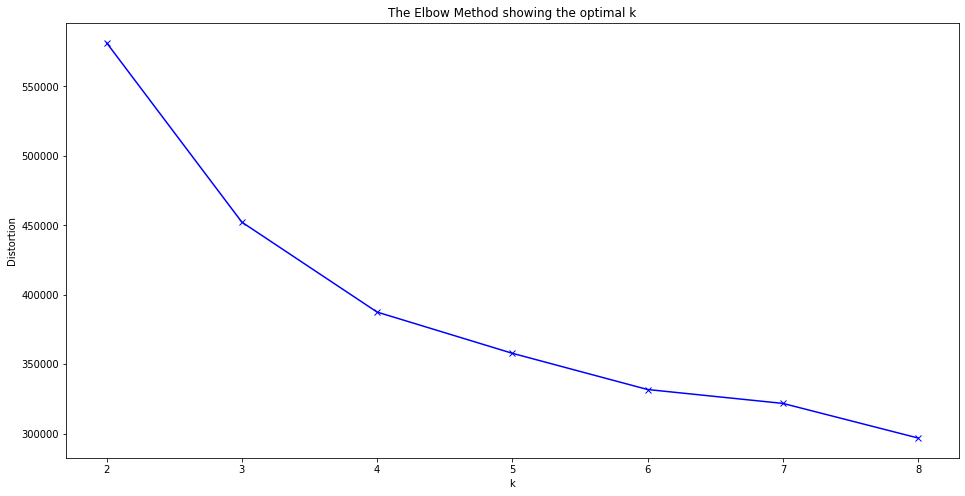

In [5]:
K=range(2,9)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [3]:
#Trainset and Testset: MIT-BIH (lead = 'MLII')
amPCV_ECG1 = amPCV[amPCV['lead']=='ECG1']
#print (amPCV_ECG1['sub'].value_counts())
X = amPCV_ECG1.drop(['sub','lead'],axis=1)
X = X.fillna(0.0)
best_score = 0.0
best_k = 1
for k in range(2,9):
    estimator = KMeans(n_clusters=k, random_state=0).fit(X)
    si_score = silhouette_score(X,estimator.labels_,metric='euclidean')
    if si_score>best_score:
        best_score = si_score
        best_k = k
print('best K is:%d and its silhouette score is:%f'%(best_k,best_score))
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
#predict every subject 
sub_list = list(set(amPCV_ECG1['sub'].tolist()))
print(len(sub_list))
rec_pvc = []
for sub in sub_list:
    PCV_sub = amPCV_ECG1[amPCV_ECG1['sub']==sub].reset_index(drop=True)
    X_sub = PCV_sub.drop(['sub','lead'],axis=1)
    X_sub = X_sub.fillna(0.0)
    pvc_num = X_sub.shape[0]
    k_sub = kmeans.predict(X_sub)
    k_num = len(list(set(k_sub.tolist())))
    if k_num>1:
        rec_pvc.append([sub,k_num,pvc_num])
print(len(rec_pvc))

best K is:2 and its silhouette score is:0.216068
131
86
